<a href="https://colab.research.google.com/github/RajkumarGalaxy/ComputerVision/blob/master/HiSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HiSD

### Hierarchical Style Disentanglement

References:

https://github.com/imlixinyang/HiSD

https://arxiv.org/abs/2103.01456

According to the authors of this research paper, the code is meant only for academic and research purpose. 

## Load pre-trained model checkpoint from offcial Google Drive page

checkpoint_256_celeba-hq.pt

In [69]:
# id = '1KDrNWLejpo02fcalUOrAJOl1hGoccBKl'
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KDrNWLejpo02fcalUOrAJOl1hGoccBKl' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KDrNWLejpo02fcalUOrAJOl1hGoccBKl" -O checkpoint_256_celeba-hq.pt && rm -rf /tmp/cookies.txt

--2021-03-26 13:14:52--  https://docs.google.com/uc?export=download&confirm=EtNa&id=1KDrNWLejpo02fcalUOrAJOl1hGoccBKl
Resolving docs.google.com (docs.google.com)... 172.253.123.113, 172.253.123.100, 172.253.123.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.123.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-04-docs.googleusercontent.com/docs/securesc/raenpb2b66ubecobq68cl0tvecioc54h/icrj5tuum1eoaskv63jcoqjkf13b2dcf/1616764425000/02095818658388140387/05326195608268963691Z/1KDrNWLejpo02fcalUOrAJOl1hGoccBKl?e=download [following]
--2021-03-26 13:14:52--  https://doc-0g-04-docs.googleusercontent.com/docs/securesc/raenpb2b66ubecobq68cl0tvecioc54h/icrj5tuum1eoaskv63jcoqjkf13b2dcf/1616764425000/02095818658388140387/05326195608268963691Z/1KDrNWLejpo02fcalUOrAJOl1hGoccBKl?e=download
Resolving doc-0g-04-docs.googleusercontent.com (doc-0g-04-docs.googleusercontent.com)... 173.194.213.132, 2607:f8b0:400c:c0a::84
Conne

In [70]:
checkpoint_name = 'checkpoint_256_celeba-hq.pt'

In [71]:
!ls

assets			     core	     examples	 preprocessors
checkpoint_256_celeba-hq.pt  easy_use.ipynb  HiSD	 README.md
configs			     easy_use.py     LICENCE.md


## Clone source code and install dependencies

In [72]:
!pip install tensorboardx

In [73]:
!git clone https://github.com/imlixinyang/HiSD.git


fatal: destination path 'HiSD' already exists and is not an empty directory.


In [74]:
%cd /content/
!mv checkpoint_256_celeba-hq.pt HiSD/

/content
mv: cannot stat 'checkpoint_256_celeba-hq.pt': No such file or directory


In [75]:
%cd HiSD/

/content/HiSD


In [76]:
!ls

assets			     core	     examples	 preprocessors
checkpoint_256_celeba-hq.pt  easy_use.ipynb  HiSD	 README.md
configs			     easy_use.py     LICENCE.md


## Prepare the environment

In [77]:
%cd /content/HiSD/
from core.utils import get_config
from core.trainer import HiSD_Trainer
import argparse
import torchvision.utils as vutils
import sys
import torch
import os
from torchvision import transforms
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt

/content/HiSD


In [78]:
## Load model and its checkpoint

In [79]:
device = 'cpu'
# load checkpoint
config = get_config('configs/celeba-hq_256.yaml')
noise_dim = config['noise_dim']
image_size = config['new_size']
checkpoint = 'checkpoint_256_celeba-hq.pt'
trainer = HiSD_Trainer(config)
# map_location=torch.device('cpu')
state_dict = torch.load(checkpoint, map_location=torch.device('cpu'))
trainer.models.gen.load_state_dict(state_dict['gen_test'])
trainer.models.gen.to(device)

E = trainer.models.gen.encode
T = trainer.models.gen.translate
G = trainer.models.gen.decode
M = trainer.models.gen.map
F = trainer.models.gen.extract

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Define a helper function to perform inference

In [80]:
def translate(input, steps):
    x = transform(Image.open(input).convert('RGB')).unsqueeze(0).to(device)
    c = E(x)
    c_trg = c
    for j in range(len(steps)):
        step = steps[j]
        if step['type'] == 'latent-guided':
            if step['seed'] is not None:
                torch.manual_seed(step['seed'])
                torch.cuda.manual_seed(step['seed']) 

            z = torch.randn(1, noise_dim).to(device)
            s_trg = M(z, step['tag'], step['attribute'])

        elif step['type'] == 'reference-guided':
            reference = transform(Image.open(step['reference']).convert('RGB')).unsqueeze(0).to(device)
            s_trg = F(reference, step['tag'])
        
        c_trg = T(c_trg, s_trg, step['tag'])
            
    x_trg = G(c_trg)
    output = x_trg.squeeze(0).cpu().permute(1, 2, 0).add(1).mul(1/2).clamp(0,1).detach().numpy()
    return output

## Inference

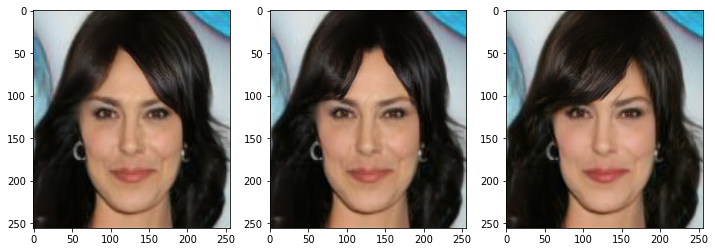

In [81]:
input = 'examples/input_0.jpg'

# e.g.1 change tag 'Bangs' to attribute 'with' using 3x latent-guided styles (generated by random noise). 
steps = [
    {'type': 'latent-guided', 'tag': 0, 'attribute': 0, 'seed': None}
]
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    output = translate(input, steps)
    plt.imshow(output, aspect='auto')
plt.show()

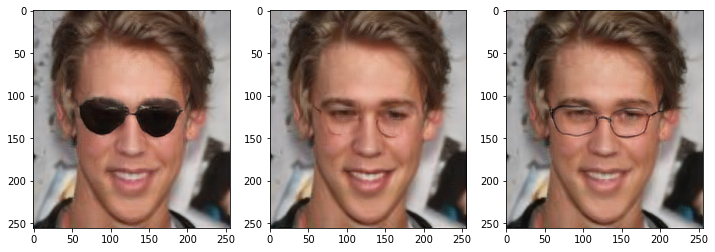

In [82]:
input = 'examples/input_1.jpg'
plt.figure(figsize=(12,4))
# e.g.2 change tag 'Glasses' to attribute 'with' using reference-guided styles (extracted from another image). 
steps = [
    {'type': 'reference-guided', 'tag': 1, 'reference': 'examples/reference_glasses_0.jpg'}
]

output = translate(input, steps)
plt.subplot(131)
plt.imshow(output, aspect='auto')

steps = [
    {'type': 'reference-guided', 'tag': 1, 'reference': 'examples/reference_glasses_1.jpg'}
]

output = translate(input, steps)
plt.subplot(132)
plt.imshow(output, aspect='auto')

steps = [
    {'type': 'reference-guided', 'tag': 1, 'reference': 'examples/reference_glasses_2.jpg'}
]

output = translate(input, steps)
plt.subplot(133)
plt.imshow(output, aspect='auto')
plt.show()

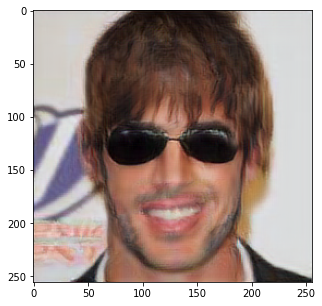

In [83]:
input = 'examples/input_2.jpg'

# e.g.3 change tag 'Glasses' and 'Bangs 'to attribute 'with', 'Hair color' to 'black' during one translation. 
steps = [
    {'type': 'reference-guided', 'tag': 0, 'reference': 'examples/reference_bangs_0.jpg'},
    {'type': 'reference-guided', 'tag': 1, 'reference': 'examples/reference_glasses_0.jpg'},
    {'type': 'latent-guided', 'tag': 2, 'attribute': 0, 'seed': None}
]

output = translate(input, steps)
plt.figure(figsize=(5,5))
plt.imshow(output, aspect='auto')
plt.show()

Thank you for your time!